#### Importing Libraries

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Class for Computing the NODF Nestedness

In [1]:
class NestednessCalculator(object):
    """Calculates the nestedness of the input matrix.

    The algorithms that have been implemented are:
        - NODF (Nestedness based on Overlap and Decreasing Fill)
    """

    def __init__(self, mat):
        """Initialize the Nestedness calculator and check the input matrix.

        :param mat: binary input matrix
        :type mat: numpy.array
        """
        self.check_input_matrix_is_binary(mat)
        self.check_degrees(mat)

    @staticmethod
    def check_input_matrix_is_binary(mat):
        """Check that the input matrix is binary, i.e. entries are 0 or 1.

        :param mat: binary input matrix
        :type mat: numpy.array

        :raise AssertionError: raise an error if the input matrix is not
            binary
        """
        assert np.all(np.logical_or(mat == 0, mat == 1)), "Input matrix is not binary."

    @staticmethod
    def check_degrees(mat):
        """Check that rows and columns are not completely zero.

        :param mat: binary input matrix
        :type mat: numpy.array

        :raise AssertionError: raise an error if the input matrix has
            completely zero rows or columns.
        """
        assert np.all(mat.sum(axis=1) != 0), "Input matrix rows with only zeros, abort."
        assert np.all(
            mat.sum(axis=0) != 0
        ), "Input matrix columns with only zeros, abort."

    ################################################################################
    # NODF - Nestedness based on Overlap and Decreasing Fill
    ################################################################################

    @staticmethod
    def get_paired_nestedness(mat, rows=True):
        """Calculate the paired nestedness along the rows or columns of the matrix.

        :param mat: binary input matrix
        :type mat: numpy.array
        :param rows: if True, pairs are calculated along the rows, if False
            along the columns
        :type rows: bool

        :returns: degree of paired nestedness
        :rtype: float
        """
        if rows:
            # consider rows
            po_mat = np.dot(mat, mat.T)
            degrees = mat.sum(axis=1)
        else:
            # consider cols
            po_mat = np.dot(mat.T, mat)
            degrees = mat.sum(axis=0)
        assert len(degrees) == len(po_mat)

        neg_delta = degrees != degrees[:, np.newaxis]
        deg_matrix = degrees * np.ones_like(po_mat)
        deg_minima = np.minimum(deg_matrix, deg_matrix.T)
        n_pairs = po_mat[neg_delta] / (2.0 * deg_minima[neg_delta])
        return n_pairs.sum()

    def nodf(self, mat):
        """Calculate the NODF nestedness of the input matrix.

        :param mat: binary input matrix
        :type mat: numpy.array

        :returns: NODF nestedness of the input matrix
        :rtype: float
        """
        n_pairs_rows = self.get_paired_nestedness(mat, rows=True)
        n_pairs_cols = self.get_paired_nestedness(mat, rows=False)
        norm = np.sum(np.array(mat.shape) * (np.array(mat.shape) - 1) / 2.0)
        nodf = (n_pairs_rows + n_pairs_cols) / norm
        return nodf

#### Loading the Liquidity Graph

In [3]:
def build_graph():
    """Build a graph from the 'top_1000_by_liquidity.csv' file.

    :returns: The built network
    :rtype: nx.Graph
    """
    df = pd.read_csv("top_1000_by_liquidity.csv")
    G = nx.from_pandas_edgelist(
        df,
        source="token0.symbol",
        target="token1.symbol",
        edge_attr="reserveUSD",
        create_using=nx.Graph().to_undirected(),
    )
    return G


G = build_graph()

#### Functions for computing the NODF nestedness for the Input Graph and it's corresponding Null Model

In [4]:
def calculate_nodf(G):
    """Calculates the NODF nestedness of the given graph G.

    :returns: The nestedness of the graph
    :rtype: float
    """
    adj = nx.to_numpy_array(G)
    calculator = NestednessCalculator(adj)
    nodf = calculator.nodf(adj)
    return nodf

In [5]:
def create_null_model(G, iter):
    """Creates a null model by randomizing the given graph G and preserving the degree distribution.

    :returns: The randomized graph
    :rtype: nx.Graph
    """
    G_rand = nx.algorithms.smallworld.random_reference(
        G, niter=iter, connectivity=False
    )
    return G_rand

In [15]:
def calculate_nodf_N_null_models(G, N, iter):
    """Calculates the average nodf of the N null models

    :returns: The average nodf
    :rtype: float
    """
    sum_nodf = 0
    for i in range(N):
        G_rand = nx.algorithms.smallworld.random_reference(
            G, niter=iter, connectivity=False
        )
        G_rand_nodf = calculate_nodf(G_rand)
        sum_nodf += G_rand_nodf
    return sum_nodf / N



In [7]:
G_nestedness = calculate_nodf(G)
G_rand_nestedness = calculate_nodf(create_null_model(G, iter=100))

print(f"Nestedness for G: {G_nestedness}")
print(f"Nestedness for randomised G: {G_rand_nestedness}")


Nestedness for G: 0.09300890661437522
Nestedness for randomised G: 0.11924592178352232


In [16]:
# TODO: randomize 100 graphs - take the avergae of the nestedness and then compare
G_N_rand_nodf = calculate_nodf_N_null_models(G, 10, 100)
print(G_N_rand_nodf)

0.11904710819887394


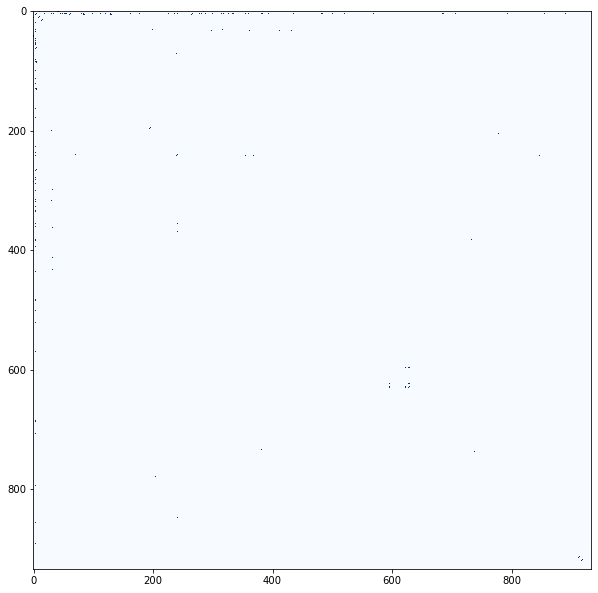

In [41]:
# Visualize the adj matrix
adj = nx.to_numpy_array(G)
df = pd.DataFrame(adj)
fig, ax = plt.subplots(figsize=(10,15)) 
plt.imshow(adj, interpolation="nearest", cmap='Blues')
plt.show()
#fig.savefig("adjmatrix.pdf", format="pdf")

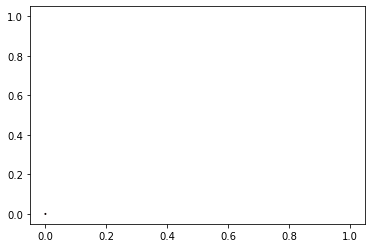

,0,1,2,3,4,5,6,7,8,9,...,924,925,926,927,928,929,930,931,932,933
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
930,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
931,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
932,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
